In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/train.csv')
test_df=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/fillna_test.csv')
sub = pd.DataFrame(test_df['time'])

In [3]:
train_df = train_df[train_df['temperature'].notnull()]
train_df = train_df.fillna(method='bfill')
test_df = test_df.fillna(method='bfill')
train_df.columns = ['time','year','month','day','hour','min','sec','outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo', 'temperature']
test_df.columns = ['time','year','month','day','hour','min','sec','outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']
data_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [4]:
#标签特征
data_df['s_hight_tem_out']=data_df['outdoorTemp'].apply(lambda x: 1 if x>25 else 0)
data_df['s_hight_hum_out']=data_df['outdoorHum'].apply(lambda x: 1 if x>83 else 0)
data_df['s_hight_hum_in']=data_df['indoorHum'].apply(lambda x: 1 if x>83 else 0)

In [6]:
# 不同粒度下的聚合特征
def short_time(x):
    if x<6:
        x=0
    elif (x<12)and(x>=6):
        x=6
    elif (x<18)and(x>=12):
        x=12
    else:
        x=18
    return x
data_df['short_time']=data_df['hour'].apply(lambda x:short_time(x))
group_mean_feats = []
group_median_feats = []
group_mad_feats = []
group_max_feats = []
group_min_feats = []
group_std_feats = []
for f in tqdm(['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']):
# hour 粒度
    data_df['MDH_{}_median'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('median')
    data_df['MDH_{}_mean'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('mean')
    data_df['MDH_{}_max'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('max')
    data_df['MDH_{}_min'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('min')
    data_df['MDH_{}_std'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('std')
    data_df['MDH_{}_mad'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('mad')
    group_mean_feats.append('MDH_{}_mean'.format(f))
    group_median_feats.append('MDH_{}_median'.format(f))
    group_mad_feats.append('MDH_{}_mad'.format(f))
    group_max_feats.append('MDH_{}_max'.format(f))
    group_min_feats.append('MDH_{}_min'.format(f))
    group_std_feats.append('MDH_{}_std'.format(f))
#天 粒度    
    data_df['MD_{}_median'.format(f)] = data_df.groupby(['month','day'])[f].transform('median')
    data_df['MD_{}_mean'.format(f)] = data_df.groupby(['month','day'])[f].transform('mean')
    data_df['MD_{}_max'.format(f)] = data_df.groupby(['month','day'])[f].transform('max')
    data_df['MD_{}_min'.format(f)] = data_df.groupby(['month','day'])[f].transform('min')
    data_df['MD_{}_std'.format(f)] = data_df.groupby(['month','day'])[f].transform('std')
    data_df['MD_{}_mad'.format(f)] = data_df.groupby(['month','day'])[f].transform('mad')
#6 hour 粒度
    data_df['MD_6H_{}_median'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('median')
    data_df['MD_6H_{}_mean'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('mean')
    data_df['MD_6H_{}_max'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('max')
    data_df['MD_6H_{}_min'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('min') 
    data_df['MD_6H_{}_std'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('std')   
    data_df['MD_6H_{}_mad'.format(f)] = data_df.groupby(['month','day','short_time'])[f].transform('mad') 
# #12 hour 粒度    
#     data_df['MD_12H_{}_median'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('median')
#     data_df['MD_12H_{}_mean'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('mean')
#     data_df['MD_12H_{}_max'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('max')
#     data_df['MD_12H_{}_min'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('min') 
#     data_df['MD_12H_{}_std'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('std')   
#     data_df['MD_12H_{}_mad'.format(f)] = data_df.groupby(['month','day','day_night'])[f].transform('mad') 
#30min 粒度    
#     data_df['MDH_30min_{}_median'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('median')
#     data_df['MDH_30min_{}_mean'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('mean')
#     data_df['MDH_30min_{}_max'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('max')
#     data_df['MDH_30min_{}_min'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('min') 
#     data_df['MDH_30min_{}_std'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('std')   
#     data_df['MDH_30min_{}_mad'.format(f)] = data_df.groupby(['month','day','30_min'])[f].transform('mad') 
print(group_mean_feats)
data_df=data_df.drop(['short_time'],axis=1)
data_df.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


['MDH_outdoorTemp_mean', 'MDH_outdoorHum_mean', 'MDH_outdoorAtmo_mean', 'MDH_indoorHum_mean', 'MDH_indoorAtmo_mean']


(25213, 106)

In [7]:
# 离散化
for f in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
#     data_df[f+'_20_bin'] = pd.cut(data_df[f], 20, duplicates='drop').apply(lambda x:x.left).astype(int)
    data_df[f+'_50_bin'] = pd.cut(data_df[f], 50, duplicates='drop').apply(lambda x:x.left).astype(int)
#     data_df[f+'_100_bin'] = pd.cut(data_df[f], 100, duplicates='drop').apply(lambda x:x.left).astype(int)
#     data_df[f+'_200_bin'] = pd.cut(data_df[f], 200, duplicates='drop').apply(lambda x:x.left).astype(int)
data_df.shape

(25213, 111)

In [8]:
#强特征outdoorTemp 聚合交叉
for f1 in tqdm( ['MDH_outdoorTemp_mean','MD_outdoorTemp_mean','MD_6H_outdoorTemp_mean','MDH_outdoorTemp_median','MD_outdoorTemp_median','MD_6H_outdoorTemp_median']):

    for f2 in  ['MDH_outdoorTemp_mean','MD_outdoorTemp_mean','MD_6H_outdoorTemp_mean','MDH_outdoorTemp_median','MD_outdoorTemp_median','MD_6H_outdoorTemp_median']:
        if f1 != f2:
            colname_div = '{}_{}_div'.format(f1, f2)
            data_df[colname_div] = data_df[f1].values / data_df[f2].values
            colname_sub = '{}_{}_sub'.format(f1, f2)
            data_df[colname_sub] = data_df[f1].values - data_df[f2].values            
# 基本交叉特征 
for f1 in tqdm(['outdoorTemp','outdoorHum','indoorHum','indoorAtmo']):
    
    for f2 in group_median_feats+group_mean_feats:
        if f1 != f2:
            colname_div = '{}_{}_div'.format(f1, f2)
            data_df[colname_div] = data_df[f1].values / data_df[f2].values
            colname_sub = '{}_{}_sub'.format(f1, f2)
            data_df[colname_sub] = data_df[f1].values - data_df[f2].values
for f1 in tqdm(['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']):
    
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
        if f1 != f2:
            colname_div = '{}_{}_div'.format(f1, f2)
            data_df[colname_div] = data_df[f1].values / data_df[f2].values
            colname_sub = '{}_{}_sub'.format(f1, f2)
            data_df[colname_sub] = data_df[f1].values - data_df[f2].values                   
# 基础mean交叉特征            
for f1 in tqdm(group_mean_feats):
    
    for f2 in  group_mean_feats:
        if f1 != f2:
            colname_div = '{}_{}_div_mean'.format(f1, f2)
            data_df[colname_div] = data_df[f1].values / data_df[f2].values
            colname_sub = '{}_{}_sub_mean'.format(f1, f2)
            data_df[colname_sub] = data_df[f1].values - data_df[f2].values
# 基础median交叉特征            
for f1 in tqdm(group_median_feats):
    
    for f2 in  group_median_feats:
        if f1 != f2:
            colname_div = '{}_{}_div_median'.format(f1, f2)
            data_df[colname_div] = data_df[f1].values / data_df[f2].values
            colname_sub = '{}_{}_sub_median'.format(f1, f2)
            data_df[colname_sub] = data_df[f1].values - data_df[f2].values
            
data_df = data_df.fillna(method='bfill')
data_df.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.28it/s]


(25213, 371)

In [9]:
data_df['dt'] = data_df['day'].values + (data_df['month'].values - 3) * 31-14
data_df['hour_add']=data_df['hour']+data_df['dt']*24
#差分:同比 前n小时的div
def yoy(data_df,n,agg_method,group_feats):
    
    for m in group_feats:
        tpm_df=pd.DataFrame()
        tpm=pd.DataFrame()
        for i in np.arange(1,721):
            a=data_df['hour_add']==i
            b=data_df['hour_add']==i-n
            if i<=n:
                tpm['yoy_{}'.format(m)]=data_df.loc[a,m].agg({agg_method})-data_df.loc[a,m].agg({agg_method})
                tpm['hour_add']=i
                tpm_df=tpm_df.append(tpm)
#                 data_df.loc[a,'yoy_{}'.format(m)]=data_df.loc[a,m].agg({agg_method})
            else:
                tpm['yoy_{}'.format(m)]=data_df.loc[a,m].agg({agg_method})-data_df.loc[b,m].agg({agg_method})
                tpm['hour_add']=i
                tpm_df=tpm_df.append(tpm)
        data_df=data_df.merge(tpm_df,on=['hour_add'],how='left')
    return data_df            
data_df=yoy(data_df=data_df,n=1,agg_method='mean',group_feats=group_mean_feats)
data_df=yoy(data_df=data_df,n=1,agg_method='median',group_feats=group_median_feats)
data_df=yoy(data_df=data_df,n=1,agg_method='max',group_feats=group_max_feats)
data_df=yoy(data_df=data_df,n=1,agg_method='min',group_feats=group_min_feats)
data_df=yoy(data_df=data_df,n=2,agg_method='mean',group_feats=group_mean_feats)
data_df=yoy(data_df=data_df,n=2,agg_method='median',group_feats=group_median_feats)
data_df=yoy(data_df=data_df,n=2,agg_method='max',group_feats=group_max_feats)
data_df=yoy(data_df=data_df,n=2,agg_method='min',group_feats=group_min_feats)
data_df.shape

(25213, 413)

In [10]:
#历史信息提取
#前n天的聚合特征
group_history_feats = []
def history_data(data,ind,n):
    for f in tqdm(['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']):
        tmp_df = pd.DataFrame()
        for t in range(1, 31):
            a=data_df['dt']<t
            b=data_df['dt']>=t-n
            c=a&b
            tmp = data.loc[c,:].groupby(['hour'])[f].agg({ind}).reset_index()
            tmp.columns = ['hour','{}_{}_{}_history_hour'.format(n,f,ind)]
            tmp['dt']=t
            tmp_df = tmp_df.append(tmp)
        data = data.merge(tmp_df, on=['dt','hour'], how='left')
        group_history_feats.append('{}_{}_{}_history_hour'.format(n,f,ind))
    return data

data_df=history_data(data=data_df,n=2,ind='mean')  
data_df=history_data(data=data_df,n=2,ind='median')    
data_df=history_data(data=data_df,n=2,ind='max')    
data_df=history_data(data=data_df,n=2,ind='min') 
data_df=history_data(data=data_df,n=2,ind='std')    
data_df=history_data(data=data_df,n=2,ind='mad') 
data_df = data_df.fillna(method='bfill')
data_df.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


(25213, 443)

In [11]:
data_df = data_df.fillna(method='bfill')
data_df.apply(lambda x:sum(x.isnull())/len(x)).reset_index()

,index,0
0,time,0.0
1,year,0.0
2,month,0.0
3,day,0.0
4,hour,0.0
...,...,...
438,2_outdoorTemp_mad_history_hour,0.0
439,2_outdoorHum_mad_history_hour,0.0
440,2_outdoorAtmo_mad_history_hour,0.0
441,2_indoorHum_mad_history_hour,0.0


In [12]:
def single_model(clf, train_x, train_y, test_x, clf_name, class_num=1):

    train = np.zeros((train_x.shape[0], class_num))
    test = np.zeros((test_x.shape[0], class_num))
    
    nums = int(train_x.shape[0] * 0.80)
    
    if clf_name in ['ridge']:
        print('MinMaxScaler...')
        for col in features:
            ss = MinMaxScaler()
            ss.fit(np.vstack([train_x[[col]].values, test_x[[col]].values]))
#             train_x[col] = ss.transform(train_x[[col]].values).flatten()
#             test_x[col] = ss.transform(test_x[[col]].values).flatten()
            train_x[col] = ss.transform(train_x[[col]].values)
            test_x[col] = ss.transform(test_x[[col]].values)
    
    trn_x, trn_y, val_x, val_y = train_x[:nums], train_y[:nums], train_x[nums:], train_y[nums:]
    if clf_name == "lgb":
        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)
        data_matrix  = clf.Dataset(train_x, label=train_y)
        
        params = {
            'boosting_type': 'gbdt',
            'objective': 'rmse',
            'min_child_weight': 5,
            'num_leaves': 2 ** 8,
            'feature_fraction': 0.5,
            'bagging_fraction': 0.5,
            'bagging_freq': 1,
            'learning_rate': 0.001,
            'seed': 2020
        }

        model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=500,early_stopping_rounds=50)
        model2 = clf.train(params, data_matrix, model.best_iteration)
        val_pred = model.predict(val_x, num_iteration=model2.best_iteration).reshape(-1,1)
        test_pred = model.predict(test_x, num_iteration=model2.best_iteration).reshape(-1,1)

    if clf_name == "xgb":
        train_matrix = clf.DMatrix(trn_x , label=trn_y, missing=np.nan)
        valid_matrix = clf.DMatrix(val_x , label=val_y, missing=np.nan)
        test_matrix  = clf.DMatrix(test_x, label=val_y, missing=np.nan)
        params = {'booster': 'gbtree',
#                   'tree_method': 'gpu_hist',
                  'eval_metric': 'rmse',
                  'min_child_weight': 5,
                  'max_depth': 6,
                  'subsample': 0.5,
                  'colsample_bytree': 0.5,
                  'eta': 0.001,
                  'seed': 2020,
                  'nthread': 36,
                  'silent': True,
                  }

        watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

        model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=50)
        val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit).reshape(-1,1)
        test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit).reshape(-1,1)

    if clf_name == "cat":
        params = {'learning_rate': 0.001,
                  'depth': 5, 
                  'l2_leaf_reg': 10,
                  'bootstrap_type': 'Bernoulli',
                  'od_type': 'Iter', 
                  'od_wait': 50, 'random_seed': 11, 
                  'allow_writing_files': False
                 }

        model = clf(iterations=20000, **params)
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  cat_features=[], use_best_model=True, verbose=500)

        val_pred  = model.predict(val_x)
        test_pred = model.predict(test_x)
    
    if clf_name == "ridge":
        params = {
                'alpha': 1.0,
                'random_state': 2020,
            }
        model = Ridge(**params)
        model.fit(trn_x, trn_y)
        val_pred  = model.predict(val_x)
        test_pred = model.predict(test_x)

    
    print("%s_mse_score:" % clf_name, mean_squared_error(val_y, val_pred))
    
    return val_pred, test_pred

In [13]:
def lgb_model(x_train, y_train, x_valid):
    lgb_train, lgb_test = single_model(lgb, x_train, y_train, x_valid, "lgb", 1)
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_valid):
    xgb_train, xgb_test = single_model(xgb, x_train, y_train, x_valid, "xgb", 1)
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_valid):
    cat_train, cat_test = single_model(CatBoostRegressor, x_train, y_train, x_valid, "cat", 1)
    return cat_train, cat_test

def ridge_model(x_train, y_train, x_valid):
    ridge_train, ridge_test = single_model(Ridge, x_train, y_train, x_valid, "ridge", 1)
    return ridge_train, ridge_test

In [14]:
drop_columns=["time","year","sec","temperature"]
train_count = train_df.shape[0]
train_df = data_df[:train_count].copy().reset_index(drop=True)
test_df = data_df[train_count:].copy().reset_index(drop=True)
features = train_df[:1].drop(drop_columns,axis=1).columns
x_train= train_df.drop(drop_columns,axis=1)
x_test= test_df.drop(drop_columns,axis=1)

y_train=(train_df['temperature'].values-train_df['outdoorTemp'].values)/train_df['MDH_outdoorTemp_mean']

In [15]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)
sub["temperature"] =xgb_test[:,0]*test_df['MDH_outdoorTemp_mean']+test_df['outdoorTemp'].values
sub.to_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/8_19_02.csv', index=False)

[0]	train-rmse:0.487744	eval-rmse:0.483433
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[200]	train-rmse:0.399467	eval-rmse:0.3977
[400]	train-rmse:0.327202	eval-rmse:0.327259
[600]	train-rmse:0.268047	eval-rmse:0.269496
[800]	train-rmse:0.219627	eval-rmse:0.222166
[1000]	train-rmse:0.18	eval-rmse:0.183413
[1200]	train-rmse:0.147573	eval-rmse:0.151614
[1400]	train-rmse:0.12104	eval-rmse:0.125497
[1600]	train-rmse:0.099331	eval-rmse:0.104172
[1800]	train-rmse:0.081574	eval-rmse:0.086812
[2000]	train-rmse:0.067056	eval-rmse:0.07267
[2200]	train-rmse:0.055192	eval-rmse:0.061135
[2400]	train-rmse:0.045507	eval-rmse:0.05178
[2600]	train-rmse:0.037608	eval-rmse:0.044225
[2800]	train-rmse:0.03118	eval-rmse:0.038113
[3000]	train-rmse:0.025962	eval-rmse:0.033191
[3200]	train-rmse:0.021742	eval-rmse:0.029255
[3400]	train-rmse:0.018344	eval-rmse:0.026105
[3600]	train-rmse:0.015623	eval-rmse:0.023604


In [24]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)
sub["temperature"] =cat_test.reshape(-1,1)[:,0]*test_df['MDH_outdoorTemp_mean']+test_df['outdoorTemp'].values
sub.to_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/8_17_02.csv', index=False)

0:	learn: 0.0461883	test: 0.0219456	best: 0.0219456 (0)	total: 216ms	remaining: 1h 11m 54s
500:	learn: 0.0315357	test: 0.0154779	best: 0.0154779 (500)	total: 33.8s	remaining: 21m 57s
1000:	learn: 0.0228655	test: 0.0134976	best: 0.0134976 (1000)	total: 1m 7s	remaining: 21m 24s
1500:	learn: 0.0178940	test: 0.0131346	best: 0.0131343 (1498)	total: 1m 41s	remaining: 20m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01311753734
bestIteration = 1557

Shrink model to first 1558 iterations.
cat_mse_score: 0.00017206978657664774


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [22]:
demo1=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/8_19_02.csv')
demo2=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/116.csv')
d_pred=demo1['temperature']*0.7+demo2["temperature"]*0.3
sub["temperature"] =d_pred
print(mean_squared_error(demo1['temperature'],demo2["temperature"]))
sub.to_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/8_09_06.csv', index=False)

0.06707555755236903


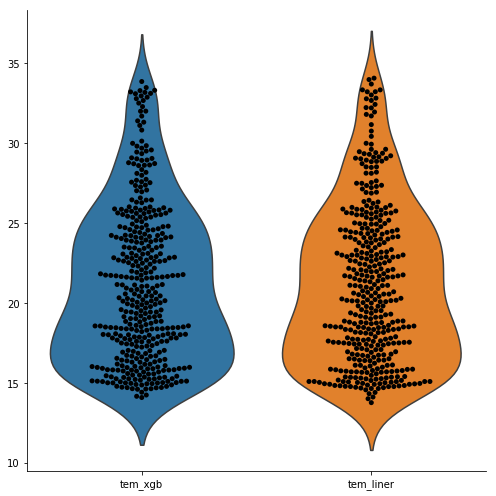

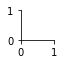

In [23]:
demo1=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/8_19_02.csv')
demo2=pd.read_csv(r'C:/Users/ZC7/Desktop/tianchi/iFLYTEK_AI/test_data/116.csv')
demo1.drop(['time'],axis=1,inplace=True)
demo1=demo1.reset_index()
demo1['tem_liner']=demo2['temperature']
demo1.columns=['index','tem_xgb','tem_liner']
demo1['div']=demo1['tem_liner']-demo1['tem_xgb']
g=sns.catplot(kind='violin',inner=None,data=demo1[['tem_xgb','tem_liner']],aspect=1,height=7)
sns.catplot(kind='swarm',color='k',size=1,data=demo1[['tem_xgb','tem_liner']],ax=g.ax)